<a href="https://colab.research.google.com/github/elango-ela/Vision-Transformers-for-Classification/blob/main/vision_transfomers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 820.2 kB/s eta 0:00:00


In [3]:
import einops
from tqdm.notebook import tqdm

from torchsummary import summary

import time

import torch
from torch import nn
import torchvision
import torch.optim as optim
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

patch_size = 16         # Patch size (P) = 16
latent_size = 768       # Latent vector (D). ViT-Base uses 768
n_channels = 3          # Number of channels for input images
num_heads = 12          # ViT-Base uses 12 heads
num_encoders = 12       # ViT-Base uses 12 encoder layers
dropout = 0.1           # Dropout = 0.1 is used with ViT-Base & ImageNet-21k
num_classes = 10        # Number of classes in CIFAR10 dataset
size = 224              # Size used for training = 224

epochs = 30             # Number of epochs
base_lr = 10e-3         # Base LR
weight_decay = 0.03     # Weight decay for ViT-Base (on ImageNet-21k)
batch_size = 4

cpu


In [5]:
# I resize the input data to 224x224, since that is the training resolution used in the paper.
# The mean and std values used to normalize CIFAR10 data is from here: https://github.com/kentaroy47/vision-transformers-cifar10/blob/main/train_cifar10.py
transform_training_data = Compose(
    [RandomCrop(32, padding=4), Resize((224)), RandomHorizontalFlip(), ToTensor(), Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

train_data = torchvision.datasets.CIFAR10(
    root='/home/achalhoub/Desktop/ViT_CIFAR10_data', train=True, download=True, transform=transform_training_data)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 73137848.03it/s]


Extracting /home/achalhoub/Desktop/ViT_CIFAR10_data/cifar-10-python.tar.gz to /home/achalhoub/Desktop/ViT_CIFAR10_data


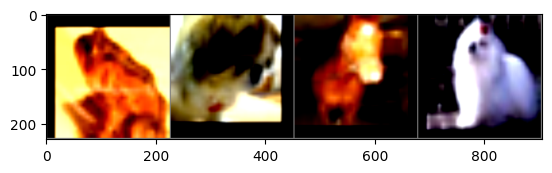

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
class InputEmbedding(nn.Module):
    def __init__(self, patch_size=patch_size, n_channels=n_channels, device=device, latent_size=latent_size, batch_size=batch_size):
        super(InputEmbedding, self).__init__()
        self.latent_size = latent_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.device = device
        self.batch_size = batch_size
        self.input_size = self.patch_size * self.patch_size * self.n_channels

        self.linearProjection = nn.Linear(self.input_size, self.latent_size)

        # Random initialization of of [class] token that is prepended to the linear projection vector.
        self.class_token = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device)

        # Positional embedding
        self.pos_embedding = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device)


    def forward(self, input_data):

        input_data = input_data.to(self.device)

        # Re-arrange image into patches.
        patches = einops.rearrange(
            input_data, 'b c (h h1) (w w1) -> b (h w) (h1 w1 c)', h1=self.patch_size, w1=self.patch_size)

        linear_projection = self.linearProjection(patches).to(self.device)
        b, n, _ = linear_projection.shape

        # Prepend the [class] token to the original linear projection
        linear_projection = torch.cat((self.class_token, linear_projection), dim=1)
        pos_embed = einops.repeat(self.pos_embedding, 'b 1 d -> b m d', m=n+1)

        # Add positional embedding to linear projection
        linear_projection += pos_embed

        return linear_projection

frog  dog   horse dog  


In [8]:
class InputEmbedding(nn.Module):
    def __init__(self, patch_size=patch_size, n_channels=n_channels, device=device, latent_size=latent_size, batch_size=batch_size):
        super(InputEmbedding, self).__init__()
        self.latent_size = latent_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.device = device
        self.batch_size = batch_size
        self.input_size = self.patch_size * self.patch_size * self.n_channels

        self.linearProjection = nn.Linear(self.input_size, self.latent_size)

        # Random initialization of of [class] token that is prepended to the linear projection vector.
        self.class_token = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device)

        # Positional embedding
        self.pos_embedding = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device)


    def forward(self, input_data):

        input_data = input_data.to(self.device)

        # Re-arrange image into patches.
        patches = einops.rearrange(
            input_data, 'b c (h h1) (w w1) -> b (h w) (h1 w1 c)', h1=self.patch_size, w1=self.patch_size)

        linear_projection = self.linearProjection(patches).to(self.device)
        b, n, _ = linear_projection.shape

        # Prepend the [class] token to the original linear projection
        linear_projection = torch.cat((self.class_token, linear_projection), dim=1)
        pos_embed = einops.repeat(self.pos_embedding, 'b 1 d -> b m d', m=n+1)

        # Add positional embedding to linear projection
        linear_projection += pos_embed

        return linear_projection

In [9]:
class EncoderBlock(nn.Module):
    def __init__(self, latent_size=latent_size, num_heads=num_heads, device=device, dropout=dropout):
        super(EncoderBlock, self).__init__()

        self.latent_size = latent_size
        self.num_heads = num_heads
        self.device = device
        self.dropout = dropout

        # Normalization layer for both sublayers
        self.norm = nn.LayerNorm(self.latent_size)

        # Multi-Head Attention layer
        self.multihead = nn.MultiheadAttention(
            self.latent_size, self.num_heads, dropout=self.dropout)


        # MLP_head layer in the encoder. I use the same configuration as that
        # used in the original VitTransformer implementation. The ViT-Base
        # variant uses MLP_head size 3072, which is latent_size*4.
        self.enc_MLP = nn.Sequential(
            nn.Linear(self.latent_size, self.latent_size*4),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.latent_size*4, self.latent_size),
            nn.Dropout(self.dropout)
        )

    def forward(self, embedded_patches):

        # First sublayer: Norm + Multi-Head Attention + residual connection.
        # We take the first element ([0]) of the returned output from nn.MultiheadAttention()
        # because this module returns 'Tuple[attention_output, attention_output_weights]'.
        # Refer to here for more info: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
        firstNorm_out = self.norm(embedded_patches)
        attention_output = self.multihead(firstNorm_out, firstNorm_out, firstNorm_out)[0]

        # First residual connection
        first_added_output = attention_output + embedded_patches

        # Second sublayer: Norm + enc_MLP (Feed forward)
        secondNorm_out = self.norm(first_added_output)
        ff_output = self.enc_MLP(secondNorm_out)

        # Return the output of the second residual connection
        return ff_output + first_added_output

In [10]:
class VitTransformer(nn.Module):
    def __init__(self, num_encoders=num_encoders, latent_size=latent_size, device=device, num_classes=num_classes, dropout=dropout):
        super(VitTransformer, self).__init__()
        self.num_encoders = num_encoders
        self.latent_size = latent_size
        self.device = device
        self.num_classes = num_classes
        self.dropout = dropout

        self.embedding = InputEmbedding()

        # Create a stack of encoder layers
        self.encStack = nn.ModuleList([EncoderBlock() for i in range(self.num_encoders)])

        # MLP_head at the classification stage has 'one hidden layer at pre-training time
        # and by a single linear layer at fine-tuning time'. For this implementation I will
        # use what was used for training, so I'll have a total of two layers, one hidden
        # layer and one output layer.
        self.MLP_head = nn.Sequential(
            nn.LayerNorm(self.latent_size),
            nn.Linear(self.latent_size, self.latent_size),
            nn.Linear(self.latent_size, self.num_classes)
        )

    def forward(self, test_input):

        # Apply input embedding (patchify + linear projection + position embeding)
        # to the input image passed to the model
        enc_output = self.embedding(test_input)

        # Loop through all the encoder layers
        for enc_layer in self.encStack:
            enc_output = enc_layer.forward(enc_output)

        # Extract the output embedding information of the [class] token
        cls_token_embedding = enc_output[:, 0]

        # Finally, return the classification vector for all image in the batch
        return self.MLP_head(cls_token_embedding)

In [11]:
model = VitTransformer(num_encoders, latent_size, device, num_classes).to(device)

# Betas used for Adam in paper are 0.9 and 0.999, which are the default in PyTorch
optimizer = optim.Adam(model.parameters(), lr=base_lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.LinearLR(optimizer)

In [14]:
def main():
    model.train().to(device)

    for epoch in tqdm(range(100), total=100):
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):

            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % 20 == 0:
                print('Batch {} epoch {} has loss = {}'.format(batch_idx, epoch, running_loss/200))
                running_loss = 0

        scheduler.step()

In [ ]:
if __name__ == "__main__":
    main()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

Batch 0 epoch 0 has loss = 0.011897943019866943
Batch 20 epoch 0 has loss = 0.23164655804634093
Batch 40 epoch 0 has loss = 0.23332677125930787
Batch 60 epoch 0 has loss = 0.2305660080909729
Batch 80 epoch 0 has loss = 0.230090434551239
Batch 100 epoch 0 has loss = 0.23119925379753112
Batch 120 epoch 0 has loss = 0.22993448138237
Batch 140 epoch 0 has loss = 0.2303127884864807
Batch 160 epoch 0 has loss = 0.23097409725189208
Batch 180 epoch 0 has loss = 0.23004745602607726
Batch 200 epoch 0 has loss = 0.23034144282341004
Batch 220 epoch 0 has loss = 0.23001781821250916
Batch 240 epoch 0 has loss = 0.23049988150596618
Batch 260 epoch 0 has loss = 0.23032811760902405
Batch 280 epoch 0 has loss = 0.23067060470581055


In [ ]:
import torch.nn as nn
import torch

class ExampleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ExampleModel, self).__init__()

        # Define a learnable parameter
        self.weight = nn.Parameter(torch.randn(input_size, output_size))

    def forward(self, x):
        # Use the learnable parameter in the forward pass
        output = torch.matmul(x, self.weight)
        return output

# Create an instance of the model
model = ExampleModel(input_size=10, output_size=5)

# Print the model's parameters
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, Size: {param.size()}")